# Disclosure on the data

The data used in this post are on high-risk gynecological patients at a Venezuelan hospital, and are from the UCI machine learning repository, available [here](https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29). No information is provided on how the data were gathered, or when. Thus, the data are not representative of women in general, or even high-risk gynecological patients. The data were selected based on their perceived risk for cervical complications; thus, models trained on the data are only valid on similarly selected test data going forward. Moreover, the data dictionary for these data is unfortunately quite lacking with the published work using these data not helping much either. The authors of the data have two published articles where they give some additional information. These articles are available [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7924508/pdf/peerj-cs-04-154.pdf) and [here](https://link.springer.com/chapter/10.1007/978-3-319-58838-4_27). Other's have also used the data, but either offer no additional details or make claims about the data that are not verifiable with materials provided by the original authors. A quick search on Google Scholar will show several papers citing the original paper, most of which use so-called "garbage can" models, with minimal or no interrogation of the source data. Several have data leakage, fail to address imbalance, and use high accuracy scores as evidence of a good classifier (despite imbalance). Thus, both because of the fact that I am not a doctor, and because the data used in this post are shakey at best, this post should be seen as an exercise in the data science process, and any publications using the data should be viewed with heavy skepticism. The results in this post should not be used for any medical decisions, and do not constitute medical advice; they are merely used to showcase data science techniques and thinking as it pertains to medical data.

Due to the above lack of clarity, the following assumptions/decisions are made regarding the data:

1. The `hinselmann`, `schiller`, `citology` and `biopsy` columns indicate a positive result upon carrying out the indicated test for cervical abnormality. I am unable to verify if this column means that the test was merely performed, or whether it was a positive result. The decision to assume that these indicate a postive test result stems from the imbalance of these columns, and knowledge of gynecological care. In the United States at least, pap smears (citology) are reccomended as routine care every 3 years after age 21. It is unlikely that of the nearly 900 patients, only about 6% of them are visiting for their every-three-year citological test. Moreover, the proportion of patients with citology is less than the proportion with biopsy. It seems strange for biopsy to occur in the absence of citology, although I am not a doctor so perhaps I'm wrong here. Thus, I assume that because these patients were deemed high risk, all tests were performed with the corresponding columns then indicating the results of these tests. 

2. The `biopsy` column is used as the outcome variable. This is consistent with the orignal authors' work. 

3. The `dx_cancer`, `dx_cin`, `dx_hpv` and `dx` columns indicate any previous cervical abnormality diagnosis has occurred. This is an assumption made based on table 1 in [this](article). 

4. The various columns indicating a particular sexually transmitted disease (STD), e.g., `stds_cervical_condylomatosis` indicate whether the patient *currently* has the indicated disease. 

5. The `stds_n_diagnosis` column is different than the `stds_number` column. I am unable to find any information regarding the `stds_n_diagnosis` column, although it could mean the number of total STD diagnoses in the patients whole history. However, because I cannot verify anything about the `stds_n_diagnosis` column, I am forced to drop it. 

# Imports

In [1]:
import gc 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import fbeta_score, make_scorer, average_precision_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib as mpl
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier
import inspect 
import warnings
import scipy.stats as stats
from tempfile import mkdtemp
from joblib import Memory
from shutil import rmtree
from mice_imputer import *
from missing_transformer import *
import pickle 

# Should model be re-run? If false, it is loaded from pkl on disk.
run = False


# Data Housekeeping
We'll first read in the data from UCI repo:

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv")

## Encode missings
The first thing you'll notice with this data (and all data from the UCI repo) is that missing values are string valued, appearing as question marks: `"?'`. So, we'll want to go through and replace these with proper missing values. 

In [3]:
df = df.replace({"?": pd.NA})

## Rename columns to be more manageable

As seen below, the column names aren't very manageable.

In [4]:
df.columns.values

array(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
       'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype=object)

We'll replace some of the keywords with abbreviations, and problem characters with underscores or white space. We'll also convert these to lower-case:

In [5]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "\(" : "",
    "\)" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"
}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values

array(['age', 'n_sexual_partners', 'first_sexual_intercourse',
       'n_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year',
       'hormonal_bc', 'hormonal_bc_years', 'iud', 'iud_years', 'stds',
       'stds_number', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_n_diagnosis',
       'stds_time_since_first_diagnosis',
       'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv',
       'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'], dtype=object)

## Dtype conversion
We'll also want to get the data into proper dtypes:

In [6]:
# convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, unsure.
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() 

# Data Exploration

## Check missingness

First, we'll check on the proportion of missing values. Remember, the mean of a binary variable is the sample proportion. Thus, below I'm just computing the mean over a boolean mask for missingness, i.e., the proportion of missing values.

In [7]:
df.isna().mean().sort_values(ascending = False)

stds_time_since_last_diagnosis        0.917249
stds_time_since_first_diagnosis       0.917249
iud                                   0.136364
iud_years                             0.136364
hormonal_bc                           0.125874
hormonal_bc_years                     0.125874
stds_pelvic_inflammatory_disease      0.122378
stds_vulvo_perineal_condylomatosis    0.122378
stds_hpv                              0.122378
stds_hepatitis_b                      0.122378
stds_hiv                              0.122378
stds_aids                             0.122378
stds_molluscum_contagiosum            0.122378
stds_genital_herpes                   0.122378
stds_syphilis                         0.122378
stds_vaginal_condylomatosis           0.122378
stds_cervical_condylomatosis          0.122378
stds_condylomatosis                   0.122378
stds_number                           0.122378
stds                                  0.122378
n_pregnancies                         0.065268
n_sexual_part

A few observations should be made here:

1. The two `time_since...` variables have too much missingness to handle, so they'll need to be dropped. 

2. The various `stds_...` columns all have identical missingness rates. There is a very high chance that patients who don't answer for one STD don't answer for any. This is a good reason to have an indicator variable for whether or not the STD columns were missing: with a single variable, we'll fit a constant term indicating whether they responded or not to the STD questions. Non-response could very well predict cancer, as these individuals may be at greater risk for STDs, which would then increase chances of cancer.

In [8]:
# Drop the time since diagnoses variables, as stated in (1) above
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

## Basic variable description
Next, its a good idea to get basic descriptives on the data to identify any clear distributional problems. In addition to summary stats, I also append the sum of values in each column. This helps to get counts for binary variables, instead of just proportions. 

In [9]:
pd.concat([df.describe().T, df.sum(axis = 0)], axis = 1)

,count,mean,std,min,25%,50%,75%,max,0
age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0,23012.000000
n_sexual_partners,832.0,2.527644,1.66776,1.0,2.0,2.0,3.0,28.0,2103.000000
first_sexual_intercourse,851.0,16.9953,2.803355,10.0,15.0,17.0,18.0,32.0,14463.000000
n_pregnancies,802.0,2.275561,1.447414,0.0,1.0,2.0,3.0,11.0,1825.000000
smokes,845.0,0.145562,0.352876,0.0,0.0,0.0,0.0,1.0,123.000000
smokes_years,845.0,1.219721,4.089017,0.0,0.0,0.0,0.0,37.0,1030.664594
smokes_packs_year,845.0,0.453144,2.22661,0.0,0.0,0.0,0.0,37.0,382.906638
hormonal_bc,750.0,0.641333,0.479929,0.0,0.0,1.0,1.0,1.0,481.000000
hormonal_bc_years,750.0,2.256419,3.764254,0.0,0.0,0.5,3.0,30.0,1692.314401
iud,741.0,0.112011,0.315593,0.0,0.0,0.0,0.0,1.0,83.000000


Again, a few observations can be made:

1. The `stds_cervical_condylomatosis` and `stds_aids` variables are constant, and will therefore be dropped. 
2. The `dx_...` and several of the other `stds_...` variables are rare/imbalanced. This will pose problems for us given the small size of this dataset, because we'll have to use nested cross validation to tune hyperparameters, and obtain risk estimates. Thus, ther is a high chance that after splitting data for cross validation, all of the positive values for these indicators will be in either the training or hold out fold. In other words, we will train a model on a constant in many cases of all postive values end up in the test fold. 
3. The three variables that index `..._years` are non-integers; i.e., they are decimal years. This can be seen by looking at the final column, which is the sum over all values of the indicated variable. The loss functions we choose for imputing these values will need to respect the fact that the support for these `..._years` variables is not strictly integers. 

This last point can also be verified by checking the modulus, although the sum being a non-integer is sufficient:

In [10]:
df_mod = df % 1 == 0
df_mod.all(axis = 0)

age                                    True
n_sexual_partners                      True
first_sexual_intercourse               True
n_pregnancies                          True
smokes                                 True
smokes_years                          False
smokes_packs_year                     False
hormonal_bc                            True
hormonal_bc_years                     False
iud                                    True
iud_years                             False
stds                                   True
stds_number                            True
stds_condylomatosis                    True
stds_cervical_condylomatosis           True
stds_vaginal_condylomatosis            True
stds_vulvo_perineal_condylomatosis     True
stds_syphilis                          True
stds_pelvic_inflammatory_disease       True
stds_genital_herpes                    True
stds_molluscum_contagiosum             True
stds_aids                              True
stds_hiv                        

In [11]:
# Dropping the constant columns, as stated in (1) above. 
const = df.nunique() == 1

if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

Deleting constant columns: ['stds_cervical_condylomatosis' 'stds_aids']


## Iud/smoking/HBC years are always >0 if you have IUD/smoke/HBC.

Notice also that we have columns like `iud` and `iud_years` or `smokes` and `smokes_years`. In theory then, `iud_years` should always be zero if `iud == 0` as well as with the smoking variables, given that the years variables are in fact decimal years. I'll check to make sure:

In [12]:
def check_zerotrunc(df, bin_col, yr_col):
    return np.any((df[bin_col] == 0) & (df[yr_col] > 0))

In [13]:
bin_cols = ["iud", "smokes", "hormonal_bc"]
yr_cols = ["iud_years", "smokes_years", "hormonal_bc_years"]

for bin, yr in zip(bin_cols, yr_cols):
    print(f"{bin} == 0 when {yr} > 0?", check_zerotrunc(df, bin, yr))

iud == 0 when iud_years > 0? False
smokes == 0 when smokes_years > 0? False
hormonal_bc == 0 when hormonal_bc_years > 0? False


As suspected, IUD is always zero when years are zero, as is the case with the smoking and hormonal birth control variables. In other words, the indicator variables are redundant: if a person has greater than 0 years for any of these variables, then we know for certain that they have the iud, they smoke, or have hormonal birth control. You can also verify the converse: when a patient has the positive indiator for IUD, smoking, or hormonal BC, they always have non-zero years for these variables. 

For some classification algorithms, this is no problem; for some, it is. In any case, the variables carry redundant information, so I drop the indicators and keep the year variables. 

## Verify that the count of stds is linear combination of all std columns. 

Notice also that we have several variables that are indicators for stds, as well as a variable for the number of stds. In theory, if the data are what we think they are, then the sum over all stds columns should be equal to the total number of stds for each patient. Checking this below shows that this is indeed the case, giving some confidence that we're thinking about these columns in the right way. 

In [14]:
all(
    (df[df.columns[df.columns.str.startswith("stds_")]].drop([
        "stds_n_diagnosis", "stds_number"]
        , axis = 1).sum(axis = 1)
        == df.stds_number).dropna()
)

True

## Verify that boolean `stds` column is always 1 if count `stds_number` column is non-zero

There is also a column simply titled `stds`, which is binary. To verify that `stds_number` is likely the current number of STDs, we can check if the `stds_number` variable is always greater than 0 when the `stds` column is non-zero, and the converse. 

In [15]:
print(
    any((df.stds.dropna() == 0) & (df.stds_number.dropna() > 0)),
    any((df.stds.dropna() == 1) & (df.stds_number.dropna() == 0)),
    sep = '\n'
)

False
False


Given that the `stds` variable just indicates the presence of any STD, we'll for sure be dropping this variable as that information is redundant.

## Combine low-proportion columns to avoid issues during cross validation

In this analysis, we'll eventually be doing k-fold cross validation. Because of the small sample size, dummy variables with low proportions (i.e., "balance") will sometimes end up with all positive (or negative) instances being in the training or test fold, which causes issues. So, I combine some std and previous diagnoses columns to avoid this, as was discussed earlier. What we'll do is create two indicator variables, one for condylomatosis-related STDs, and one for all other STDs. This results in greater balance to avoid issues with constant columns during cross validation, but also preserves some of the information about the type of STD, namely those related to condyloma, which is often associated with genital cancers. 

For similar reasons, the previous diagnoses variables are combined into a single variable indicating any previous cervical diagnosis, regardless of its type.

In [16]:
df.columns[df.columns.str.contains("stds_")]

Index(['stds_number', 'stds_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_hiv', 'stds_hepatitis_b',
       'stds_hpv', 'stds_n_diagnosis'],
      dtype='object')

In [17]:
# get two masks, one for condylomas, and one for all STDs
condy_mask = df.columns.str.contains("condy")
std_mask = (df.columns.str.startswith("stds_")) & (~df.columns.str.startswith("stds_n"))

# Get the names of condyloma stds, and names for all other stds
condy = df.columns[condy_mask]
stds = df.columns[std_mask]
not_condy = df.columns[(~condy_mask) & (std_mask)]

In [18]:
# Compute max over the entire set of condyloma or other STDs in order to get an indicator for each category.
stds_condy = df[condy].max(axis = 1)
stds_other = df[not_condy].max(axis = 1)

In [19]:
# drop old STD vars, add new ones to DF
df = df.drop(stds, axis = 1)
df = df.drop("stds", axis = 1)
df["stds_condy"] = stds_condy
df["stds_other"] = stds_other

In [20]:
# combine the previous dx columns into one, in the same way as we did for STDs: get a mask, subset columns, take max, replace.
dx_mask = df.columns.str.startswith("dx")
dx = df.columns[dx_mask]

dx_any = df[dx].max(axis = 1)

df = df.drop(dx, axis = 1)

df["dx_any"] = dx_any

df = df.convert_dtypes()

## Drop n_diagnosis col

As was already mentioned, the `stds_n_diagnosis` column is not well understood, and is therefore dropped. 

In [21]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

## Correlations

We'll also quickly check for collinearity. 

1. Looks like the two STD indicators we created are highly related to the count of the number of STDs, which of course makes sense as you can't have non-zero STDs without one of these indicators being positive. 

2. Additionaly, each of the tests (e.g., citology, Schiller, etc) are related, which is to be expected. Each test has its own false positive rate, but in general they should agree more so than by chance. 

3. All of the smoking variables, IUD, and hormonal BC variables are related to eachother. This is again expected, as within each group, the variables are functions of eachother.

4. No other strong collinearities are detected.

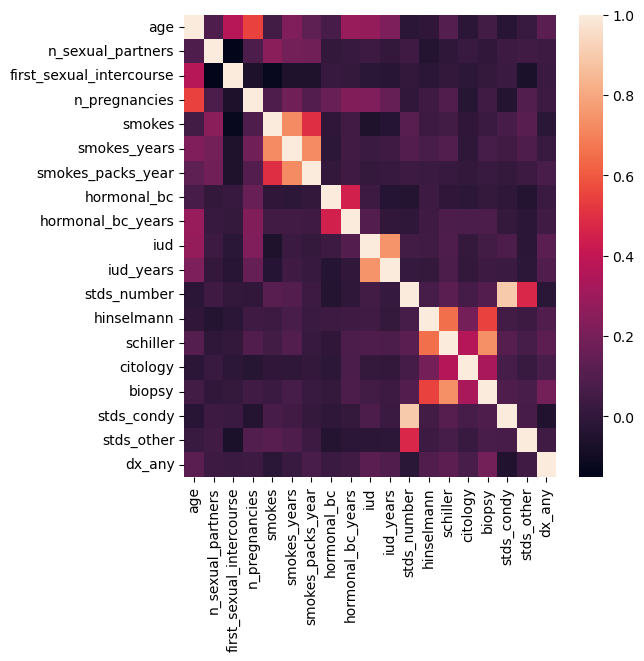

In [22]:
mpl.rcParams['figure.figsize'] = [6, 6]

corr = df.corr(numeric_only=True)
cols = corr.columns

corrs = sns.heatmap(
    corr, 
    xticklabels = cols,
    yticklabels = cols
)

## Distributions

For non-categorical variables, we'll want to get a look at the distributions. We already have an idea of how things will look from the previous summary stats, but visualizing these makes things much clearer. 

1. Each of the variables has a few outliers, but nothing that should be overly concerning. 

2. The smoking and hormonal BC years variables have point-masses at zero, as expected based on the earlier analysis of these variables. The `..._years` columns will be zero when the individuals do not participate in these behaviors. Given that most people do not participate, we have a large point mass in each of the two distributions at zero. Notice that basically no one smokes in this sample (or no one reports smoking), so our ability to detect the effect of smoking will be muted. 

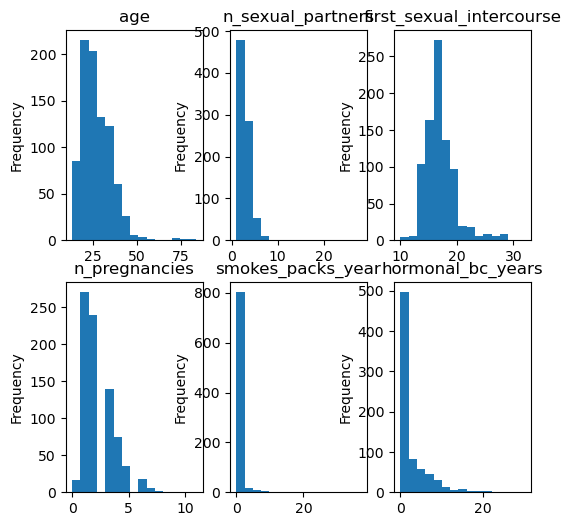

In [23]:
to_hist = ["age", "n_sexual_partners", "first_sexual_intercourse", "n_pregnancies", "smokes_packs_year", "hormonal_bc_years"]
fig, axs = plt.subplots(nrows = 2, ncols = 3)
plt.rcParams['figure.figsize'] = [15, 7]
for ax, var in zip(axs.ravel(), to_hist): 
    df[var].plot.hist(bins = 15, ax = ax, title = var)

## Final descriptives

After all the data manipulation, we'll do one last spot check to make sure things are looking as expected. All binary variables are in fact...binary, missingness rates appear small, and binary variables are not too rare. With maybe the exception of the age variable, there aren't extreme outliers.

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
n_sexual_partners,832.0,2.527644,1.66776,1.0,2.0,2.0,3.0,28.0
first_sexual_intercourse,851.0,16.9953,2.803355,10.0,15.0,17.0,18.0,32.0
n_pregnancies,802.0,2.275561,1.447414,0.0,1.0,2.0,3.0,11.0
smokes,845.0,0.145562,0.352876,0.0,0.0,0.0,0.0,1.0
smokes_years,845.0,1.219721,4.089017,0.0,0.0,0.0,0.0,37.0
smokes_packs_year,845.0,0.453144,2.22661,0.0,0.0,0.0,0.0,37.0
hormonal_bc,750.0,0.641333,0.479929,0.0,0.0,1.0,1.0,1.0
hormonal_bc_years,750.0,2.256419,3.764254,0.0,0.0,0.5,3.0,30.0
iud,741.0,0.112011,0.315593,0.0,0.0,0.0,0.0,1.0


# Modeling

Before we jump into the modeling, please be aware that I drop all tests other than the citology (pap) test. This is one so as to mimick a more routine care scenario, where at the 3 year mark a woman would most likely have the test done regardless of risk level. In other words, I drop the `hinselmann` and `schiller` test results for the analysis. This reduces the average precision of the model by about 50%, from 0.64 to 0.31. Again, the purpose of this analysis is more to show some steps in the process for data science, as of course neither of these average precision levels is very desireable. 

For model baselines, I compare to the results of table 3 in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7924508/pdf/peerj-cs-04-154.pdf) paper, namely the citology-only results.

## Separate covariates from outcome, drop unnecessary columns

Here we can drop the redundant indicator variables mentioned earlier, as well as the Hinselmann and Schiller variables as just discussed.

In [25]:
x = df.drop(["smokes", "hormonal_bc", "iud","biopsy", "hinselmann", 'schiller'], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop("stds_number", axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")

## Have to have cat/float/int dtypes for lgbm

Because we'll be using LightGBM for the model, the dtypes need to be either categorical, float, or integer. However, we can't cast vectors with missing values to ints in python, so for now I cast everything over to float.

In [26]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float')
x.dtypes

age                         float64
n_sexual_partners           float64
first_sexual_intercourse    float64
n_pregnancies               float64
smokes_years                float64
smokes_packs_year           float64
hormonal_bc_years           float64
iud_years                   float64
citology                    float64
stds_condy                  float64
stds_other                  float64
dx_any                      float64
n_stds                      float64
dtype: object

## Instantiate base classifier

Here we'll just instantiate the base LGBM classifier. The parameters are somewhat unimportant as we'll run a search over most of them anyway. However, the `is_unbalance` parameter should be set here, as this is LGBM's way of balancing class weights, which we definitely want to do. In my experience, class weighting performs as well if not better than the more fancy up-sampling or down-sampling techniques, and its very easy to implement, so we'll stick with that for now. 

In [27]:
clf = LGBMClassifier(objective = "binary", is_unbalance = True)

## Imputation parameters setup

We have missing values that we'll need to impute. In the reference paper mentioned at the beginning of this section, the authors use constant imputation. In contrast, I will do a random search over two imputation methods, a constant imputer and a MICE imputer. The MICE imputer is carried out using lightGBM through the [miceforest](https://github.com/AnotherSamWilson/miceforest) package. As lightGBM requires you to specify the objective function used for the outcome, I therefore specify the objective function to be used for each variable that will be imputed, and for binary variables, I specify that they are unbalanced. 

Also note that `miceforest` does not explicitly support the `sklearn` API when thrown into a grid/random search (despite the claims on it's github). Thus, I provide the `mice_imputer.py` module, which subclasses the `miceforest` imputer to be compatible with the `sklearn` API. The details of this module are available on my GitHub page.

In [28]:
template = {
    "objective" : "regression"
}

varparms = {}

keys = x.columns.values[x.isna().any()] 

for i in keys: 

    varparms[i] = template.copy()

    if "stds_" in i: 
        varparms[i]["objective"] = "binary"
        varparms[i]["is_unbalance"] = True

    if (x[i].nunique() > 2) & (np.all(x[i].dropna() % 1 == 0)):
        varparms[i]["objective"] = "poisson"

In [29]:
varparms

{'n_sexual_partners': {'objective': 'poisson'},
 'first_sexual_intercourse': {'objective': 'poisson'},
 'n_pregnancies': {'objective': 'poisson'},
 'smokes_years': {'objective': 'regression'},
 'smokes_packs_year': {'objective': 'regression'},
 'hormonal_bc_years': {'objective': 'regression'},
 'iud_years': {'objective': 'regression'},
 'stds_condy': {'objective': 'binary', 'is_unbalance': True},
 'stds_other': {'objective': 'binary', 'is_unbalance': True},
 'n_stds': {'objective': 'poisson'}}

## Set predictive mean matching scheme for imputer

When imputing categorical variables, its best to use predictive mean matching in order to preserve the distribution of the variables. I set the mean matching scheme to use the 5 nearest neighbors. For more details, view the readme on [this repo](https://github.com/AnotherSamWilson/miceforest). 

In [30]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

## Setup pipeline components, instantiate pipe

Next, I set up each of the pipeline components that will be used during a random search for optimal parameters, and risk estimation. These steps consist of: 

1. Impute missing values, tuning either constant imputation (`simple_union`) or mice imputation (`mice_union`)
2. Add a single missingness variable for the sexual history related variables, as this constitutes the bulk of the missingness.
3. Train/tune LGBM classifier

To do step (2), I provide the `missing_transformer.py` module, which just permits us to add a *single* missing value indicator for a subset of columns in an `sklearn` pipeline. This is distinct from `sklearn.impute.MissingIndicator`, which creates separate indicators for every variable. Instead, I take a subset of variables, and if any of them is missing, then a single indicator is coded as 1, otherwise 0. This avoids perfect collinearity in the missingness indicators for the STD columns.

Previously, I instantiated the pipeline with a memory cache in order to not have to impute the data except when the folds change. However, the disk-read overhead ends up being too high, so this is now commented out. This is an area for improvement for someone more skilled than I, as right now sklearn caches on disk, as opposed to in RAM, which would be superior in terms of speed.

In [31]:
simple_union = FeatureUnion(
    transformer_list=[
         ('features', SimpleImputer(strategy='median')),
         ('indicator', missing_transformer())
         ]
)

mice_union = FeatureUnion(
    transformer_list=[
         ('features', mice_imputer(mean_match_scheme = mean_match, mice_iterations = 15, variable_parameters = varparms)),
         ('indicator', missing_transformer())]
)

#cachedir = mkdtemp()
#memory = Memory(location=cachedir, verbose=0)
pipe = Pipeline(
    #memory = memory,
    steps = [
        ("imputer", simple_union),
        ("classifier", clf)
    ]
)

## (Some) Marginal distributions for random search

LightGBM is a tree-based boosting algorithm, so we'll need to tune a host of parameters. To do so, I employ a random search, with two of the less intuitive distributions used in this search being visualized below. Namely, we have:

1. For the number of boosting rounds, I use a negative binomial distribution and add 1 to all values to avoid zero boosting rounds as a possibility. The parameters used in the distribution and it associated probability mass function as well as some summary statistics can be found below. 

2. For the learning rate, I use an exponential distribution, with parameters chosen such that smaller learning rates are given greater probability than larger ones. Again, details on the distribution are found below.

3. For other parameters, I use discrete uniform distributions with limits chosen appropriately for each. These are found in the code cells below. 

In [32]:
plt.rcParams['figure.figsize'] = [5, 5]

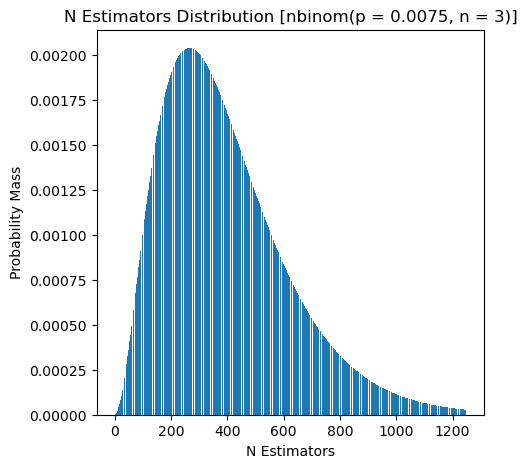

In [33]:
n = 3
p = .0075
xl = np.floor(np.linspace(0, 1250, 1250))
fig, ax = plt.subplots()

nb = ax.bar(
    xl, 
    stats.nbinom.pmf(xl, n = n, p = p, loc = 1)
)
ax.set_title(f"N Estimators Distribution [nbinom(p = {p}, n = {n})]")
ax.set_ylabel("Probability Mass")
ax.set_xlabel("N Estimators")
plt.show()

In [34]:
mn = n*(1-p)/p
st = np.sqrt(mn*p**-1)
ps = [.01, .1, .25, .5, .75, .9, .99]
qs = stats.nbinom.ppf(ps, n = n, p = p)
qs = {str(p) : q for p,q in zip(ps, qs)}
qs["mean"] = mn 
qs["std"] = st 

print("Percentiles, mean, and standard deviation of theoretical distribution:")
pd.DataFrame(qs, index = ["value"])

Percentiles, mean, and standard deviation of theoretical distribution:


,0.01,0.1,0.25,0.5,0.75,0.9,0.99,mean,std
value,56.0,145.0,228.0,354.0,519.0,705.0,1115.0,397.0,230.072452


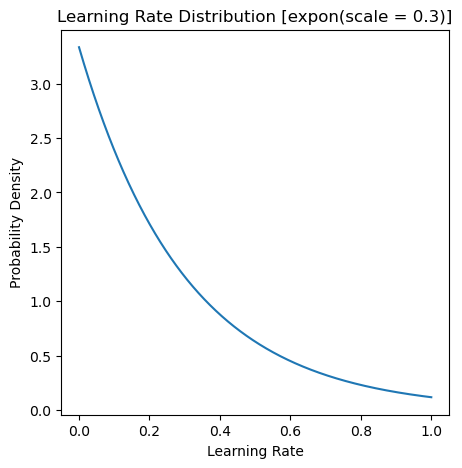

In [35]:
scale = .3
xl = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()

ex = ax.plot(
    xl, 
    stats.expon.pdf(xl, scale = scale)
)
ax.set_title(f"Learning Rate Distribution [expon(scale = {scale})]")
ax.set_ylabel("Probability Density")
ax.set_xlabel("Learning Rate")
plt.show()

In [36]:
mn = scale
st = scale
ps = [.01, .1, .25, .5, .75, .9, .99]
qs = stats.expon.ppf(ps, scale = scale)
qs = {str(p) : q for p,q in zip(ps, qs)}
qs["mean"] = mn 
qs["std"] = st 

print("Percentiles, mean, and standard deviation of theoretical distribution:")
pd.DataFrame(qs, index = ["value"])

Percentiles, mean, and standard deviation of theoretical distribution:


,0.01,0.1,0.25,0.5,0.75,0.9,0.99,mean,std
value,0.003015,0.031608,0.086305,0.207944,0.415888,0.690776,1.381551,0.3,0.3


## Define random search grid

Here we just input the specified distributions for each parameter to the "grid." The `base_grid` is common to both the `mice` and `simple` imputation schemes. 

In [37]:
lr_dist = stats.expon(scale = scale)
ne_dist = stats.nbinom(n = n, p = p, loc = 1)
nl_dist = stats.randint(2, 51)
md_dist = stats.randint(1, 10)
pc_dist = stats.randint(1, 2)
mc_dist = stats.randint(15, 75)

base_grid = {
    "classifier__n_estimators" : ne_dist,
    "classifier__num_leaves" : nl_dist,
    "classifier__max_depth" : md_dist,
    "classifier__learning_rate" : lr_dist,
    "classifier__min_child_samples" : mc_dist
}

grid = [
    {
        "imputer" : [simple_union],
        "imputer__features__strategy" : ["median"],
        **base_grid
    },
    {
        "imputer" : [mice_union],
        "imputer__features__lgb_iterations" : ne_dist,
        "imputer__features__lgb_learning_rate" : lr_dist,
        "imputer__features__lgb_max_depth" : md_dist,
        "imputer__features__lgb_num_leaves" : nl_dist,
        **base_grid
    }
]

## Setup nested CV folds, flush RAM

For the following reasons, it is appropriate to use nested, repeated, stratified K-fold cross validation. 

1. For the cross validation, we want to both tune hyperparameters, and estimate the selected model's risk. This requires nested cross validation in order to avoid data leakage. 

2. We have imbalanced data, so stratifying to preserve the class distribution will be done. 

3. We have a small data set with class imbalance, so we'll want to repeat this process to reduce the variance on our estimate of the risk. 

In [38]:
inner_cv = StratifiedKFold(n_splits = 5, random_state = 874841, shuffle = True)
outer_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 878571)

In [39]:
# Flush ram before fit
gc.collect()

50

## Fit model, cleanup, and save

Note that before fitting the model, I define a scoring criteria for model selection. I define an F2 scorer, which is analogous to the F1 score, but puts twice as much weight on the recall when computing the geomtric mean. This is one because of the context of the problem we're solving: we want to predict cancer. Thus, false negatives are costly, much more so than false positives. Of course, we want to minimize invasive procedures, but this is not nearly as problematic as failing to catch cancer. In fact, the case could be made to just use recall as the scoring criteria here. In any case, I weight recall twice as heavily than precision when computing the F-score here.

Finally, we'll parallelize the outer cross validation loop, and leave the inner one serial. 

In [40]:
def save_obj(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

f_scorer = make_scorer(fbeta_score, beta = 2)

rcv = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = grid, 
    scoring = f_scorer,
    refit = True, 
    cv = inner_cv,
    return_train_score = True,
    n_jobs = 1,
    n_iter = 500,
    random_state = 97417
)

if run:
    res = cross_validate(
        rcv, 
        X = x, 
        y = y.values.flatten(), 
        cv = outer_cv, 
        return_estimator = True, 
        scoring = ["average_precision", "balanced_accuracy", "f1", "precision", "recall"],
        n_jobs = -1,
        verbose = 999
    )

    save_obj(res, "./rcv.pkl")
else: 
    with open("./rcv.pkl", "rb") as f:
        res = pickle.load(f)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................

In [41]:
# remove memory object if it exists, flush RAM again.
try:
    rmtree(cachedir)
except:
    print("No cache to remove.") 

gc.collect()

No cache to remove.


6954

# Post-estimation analysis

## Selecting a "best" model

First thing is we'll need to determine the best estimator. With nested cross validation this can be tricky, as different parameters can be chosen for each inner cv loop. Moreover, we are using a boosting algorithm, so multiple of the parameters trade-off against eachother, for example the learning rate and the number of boosting rounds. Thus, two seemingly-different models can often achieve the same performance.

The first thing to do here is to see if the results are stable. First, I see whether either imputation strategy dominates by checking the length of the chosen parameter vector; if either imputation method wins every time, then the number of unique lengths for the chosen parameter vector will be 1, otherwise 2.

Doing this below we see that sometimes the MICE imputer won, other times the median imputer won. So the next step will be to see how stable the results are across each of these sets of models. 

In [42]:
lens = [len(est.best_params_) for est in res['estimator']]
np.unique(lens)

array([ 7, 10])

To take a look at the models, I create a table of the number of parameters, the best (training) score, and the learning rate for each of the winning models. Note that if the learning rate is the same between any pair of models, then we can be certain that this pair of models also has the same values for all other parameters (i.e., they have the same specification), as the probability of sampling the same exact learning rate from a continuous distribution is zero. Thus, by putting the learning rate in the table below, I'm effectively seeing if the same model was selected or not. 

In [43]:
best_parms = list(map(lambda x: x.best_params_, res["estimator"]))

In [44]:
best_parms = [est.best_params_ for est in res["estimator"]]
best_inner_scores = [est.best_score_ for est in res["estimator"]]
best_rate = [parms["classifier__learning_rate"] for parms in best_parms]
best_parms_7 = [parms for parms in best_parms if len(parms) == 7]
best_parms_10 = [parms for parms in best_parms if len(parms) == 10]


In [45]:
pd.DataFrame(
    [i for i in zip(lens, best_inner_scores, best_rate)], 
    columns = ['n_parms', "f2_score_inner", "classifier_learning_rate"]
).sort_values("f2_score_inner", ascending=False)

,n_parms,f2_score_inner,classifier_learning_rate
3,10,0.469256,0.112633
6,10,0.464832,0.021446
19,10,0.459399,0.068610
8,10,0.457539,0.112633
22,10,0.440894,0.039132
12,10,0.440056,0.112633
18,10,0.438795,0.112633
14,10,0.435222,0.112633
4,10,0.435016,0.420959
16,10,0.434067,0.210302


Looking at the table above, we can see that the model with the learning rate of ~0.113 has the best inner cv score, and appears often in the top half of selected models. Moreover, it is selected in a plurality of models, and its estimated F2 score is somewhat stable around the 0.45 mark. Thus, I select his model as the "best" model, and refit on the entire dataset.

In [46]:
best_final = best_parms[3]
final = pipe.set_params(**best_final)
final.fit(x, y.values.flatten())

Pipeline(steps=[('imputer',
                 FeatureUnion(transformer_list=[('features',
                                                 mice_imputer(lgb_iterations=266,
                                                              lgb_learning_rate=0.13709275624689288,
                                                              lgb_max_depth=6,
                                                              lgb_num_leaves=44,
                                                              mean_match_scheme=<miceforest.MeanMatchScheme.MeanMatchScheme object at 0x7ff7bc8177c0>,
                                                              mice_iterations=15,
                                                              variable_parameters={1: {'objective': 'poisson'},
                                                                                   2: {'objective': 'poisson'}...
                                                                                   7: {'objective': 'regression'},
                                                                                   9: {'is_unbalance': True,
                                                                                       'objective': 'binary'},
                                                                                   10: {'is_unbalance': True,
                                                                                        'objective': 'binary'},
                                                                                   12: {'objective': 'poisson'}})),
                                                ('indicator',
                                                 missing_transformer())])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.11263311888445775, max_depth=1,
                                min_child_samples=16, n_estimators=399,
                                num_leaves=6, objective='binary'))])

Several estimated performance metrics for the model then follow below. Based on work by the original authors, this model outperforms most of the models they consider for the citology-only case, found in [table 3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7924508/pdf/peerj-cs-04-154.pdf). This performance was achieved without any deep learning or other computationally intensive tricks, but with good data preprocessing and analysis. 

In [47]:
mn = []
sd = []
names = []

for i in res.keys():
    if i.startswith("test"):
        names.append(i)
        mn.append(res[i].mean())
        sd.append(res[i].std())

pd.DataFrame({
    "mean": mn, 
    "sd" : sd
    },
    index = names
)

,mean,sd
test_average_precision,0.310867,0.132079
test_balanced_accuracy,0.703057,0.081141
test_f1,0.314558,0.088469
test_precision,0.228899,0.066977
test_recall,0.530909,0.173786


## Variable importance

Note that both of the variable importance metrics computed below have drawbacks. I encourage readers to do their own research on both permutation importance and partial dependence in order to become familiar with what problems these approaches have. 

Additionally, *these are computed on the full dataset*. This is done because the dataset is so small that a train/val/test split was not done; k-fold cross-validation was used. In otherwords, computing these quantitities on a test set wouldn't be very accurate, as there is not enough data to do so. Thus, these importances are biased towards finding an effect, as they are computed on the training data. 

### Permutation Importance

I first compute the permutation variable importance. Briefly, this just takes each column, randomly shuffles it, and re-scores the model using the shuffled variable. If the variable is useful in reducing the loss (or improving the score), then shuffling it randomly should cause the score to decrease, or the loss to increase. In contrast, if it is unimportant, then shuffling it should result in little or no change in the loss/score. 

Permutation importance offers the advantage of being computable on the test set, whereas the typical mean decrease importance metric is necessarily computed on the training data. That said, I do compute the permutation importance on the training data here, as was discussed in the introduction to this section.

In [48]:
if run:
  imp = permutation_importance(
    final, 
    x, 
    y.values.flatten(),
    scoring = f_scorer,
    n_repeats = 500,
    random_state = 897447,
    n_jobs=-1
  )
  
  save_obj(imp, "./perm.pkl")
else:
  with open("./perm.pkl", "rb") as f:
    imp = pickle.load(f)

imp_sort = imp.importances_mean.argsort()
imp_df = pd.DataFrame(
    imp.importances[imp_sort].T,
    columns = x.columns[imp_sort]
)

Text(0.5, 1.0, 'Permutation Importance 95% Normal Approx. Confidence Interval')

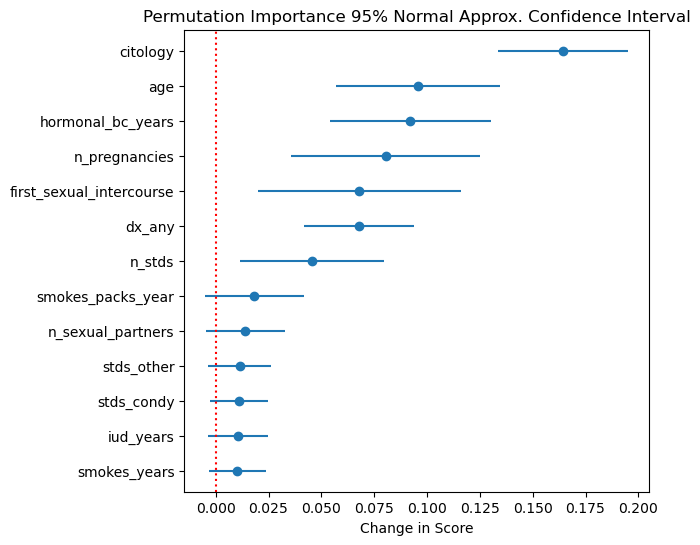

In [49]:
mpl.rcParams['figure.figsize'] = [6, 6]
bplot = plt.errorbar(x=imp_df.mean(), y = imp_df.columns, xerr = 1.96*imp_df.std(), linestyle='None', marker='o')
plt.axvline(x = 0, color='red', linestyle = ':')
plt.xlabel("Change in Score")
plt.title("Permutation Importance 95% Normal Approx. Confidence Interval")

Based on the above permutation importance plot, there is statistical reason to believe that citology results, age, hormonal BC, number of pregnancies, age at first sexual intercourse, and any previous cervical diagnosis are all driving the predictive power behind the chosen model. However, one of the known drawbacks of permutation importance is that it merely reflects the importance of the variable for the model; thus, if the model is bad (which in this case, it is, as the data is not so great), then we may not find important features where we would if the model were better.

### Partial Dependence

Next, I compute the partial dependence of each feature. Partial dependence computes average effect of a variable on the predicted probability, marginalizing over all other variables. Mathematically we have the theoretical expectation, and its sample-based estimator below (from [section 4.1.3](https://scikit-learn.org/stable/modules/partial_dependence.html#mathematical-definition) of the sklearn documentation):

$$\frac{1}{n}\sum_i g(x_S, x_C^{(i)}) \overset{p}{\rightarrow} \mathbb{E}_{X_c}[g(x_s, X_c)] = \int g(x_S, x_C) dF_{X_c}$$

where $g()$ computes the predicted probability of an estimator, $X_s$ is the set of variables we're interested in computing the partial dependence of, while $X_c$ is the set of remaining variables, and the right-hand integral is the Riemann-Stieltjes integral. 

In words then, we do the following to estimate partial dependence for a single feature $X_s$ (e.g., age):

1. For each value of interest, $x_s$ (e.g., age = 18, 19, ..., 75): 
    * set the value of variable $X_s$ to $x_s$ for all observations $i$, keeping the other variables $X_c$ at their original values. (e.g., set age variable to 18 for everyone, keep everything else the same)
    * compute the predicted probability of all observations, $g(x_s, x_c) \forall i$, (i.e., "what is the predicted probability of each observation *if we set age to 18*")
    * compute the sample mean of these predicted probabilities over all observations, (i.e., "what is the average predicted probability if we set age to 18 for all observations.")

At the end, we have the average predicted probability at each value of age, which we call the the partial dependence. 

Computing these below, we then have the count of observations indicated on the right-hand axis of each plot, with the histogram corresponding to this axis, or the grey points for binary variables.

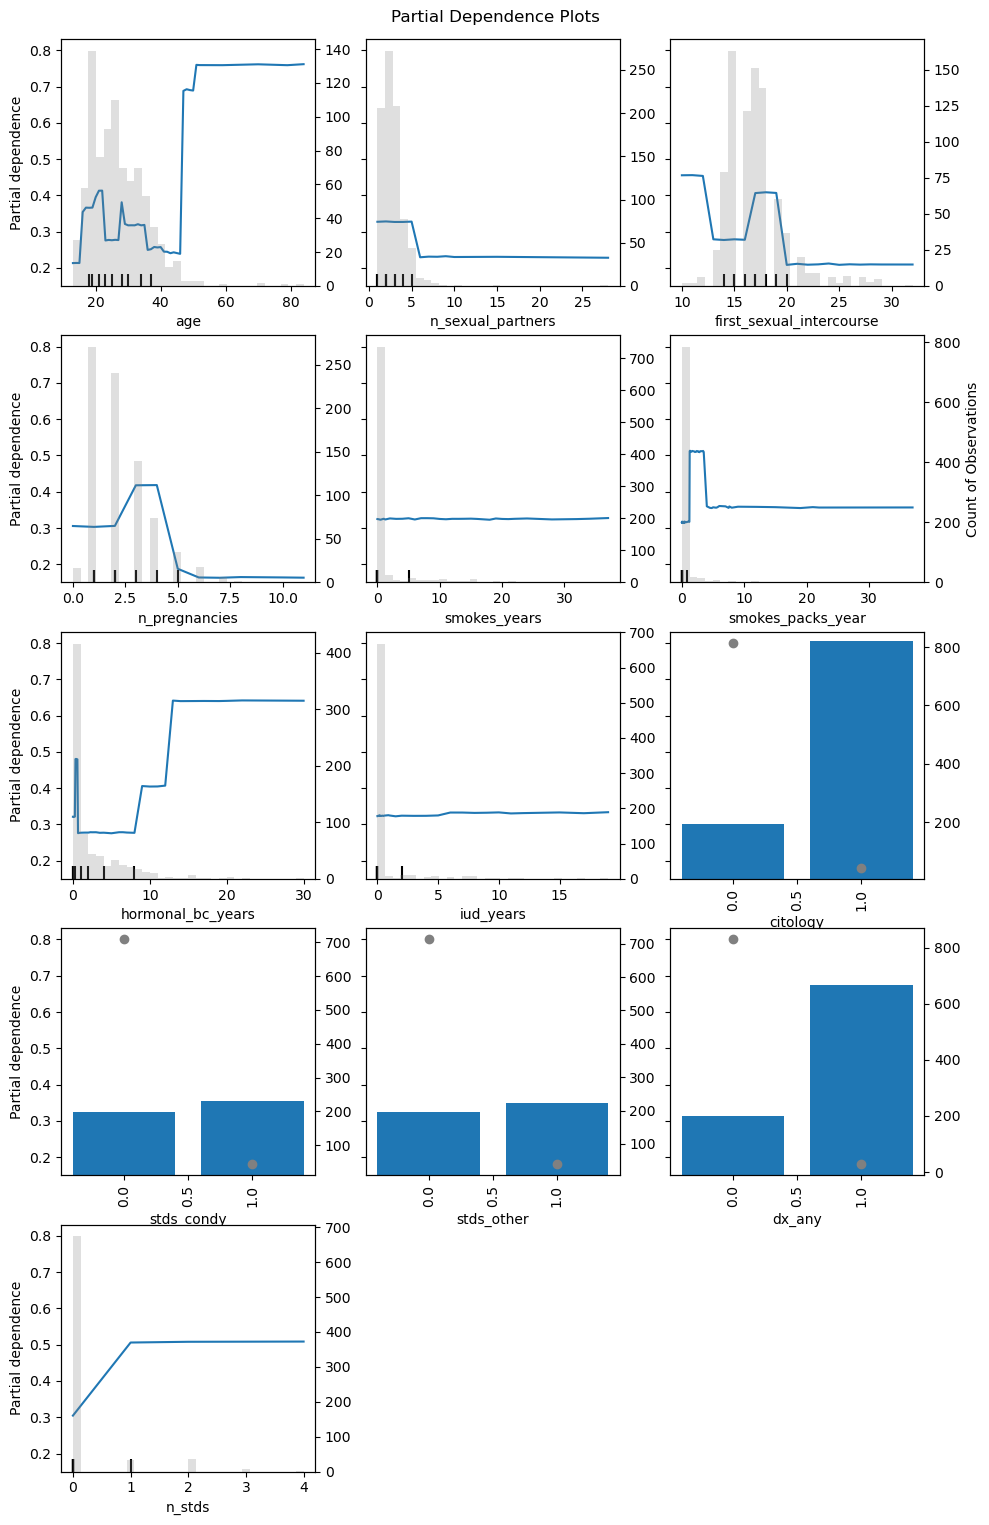

In [50]:
mpl.rcParams['figure.figsize'] = [10, 16]

is_cat = x.apply(func = lambda x: x.nunique() == 2) 

pdep = PartialDependenceDisplay.from_estimator(final, x, features = x.columns.values, grid_resolution=1000, categorical_features=is_cat, n_jobs = -1)

fts = np.array(pdep.features).flatten()
ft_names = x.columns.values[fts]

for ax, var, ft_ind in zip(pdep.axes_.ravel(), ft_names, fts):

    sec_ax = ax.twinx()


    if ft_ind == 5:
        sec_ax.set_ylabel("Count of Observations")

    if is_cat[ft_ind]:
        sec_ax.scatter(x = [0, 1], y = x.groupby(var)[var].count(), c='grey')
    else: 
        sec_ax.hist(x[var], bins = 30, color = 'grey', alpha = .25)

plt.suptitle("Partial Dependence Plots")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])


Computing these partial dependencies, we can observe the following:

1. Middle aged women tend to have a higher risk of cervical cancer, consistent with current medical understanding. Although the plot spikes in later years, we can see that there is very little data in the right-tail, so results there are suspect. 
2. Number of sexual partners most likely has no strong effect. Despite some fluctuation, this occurs in locations with little data. 
3. The age at first sexual intercourse is difficult to make claims about. It appears that first intercourse occurring between ages 15-20 may be associated with greater risk, but again there is little data in the two tails, so this is probably an artifact. 
4. Having 3-4 pregnancies may be associated with greater risk, but again, data...
5. Surprisingly, the number of years smoking has no effect on risk; the quantity of cigarattes smoked, however, does increase risk of cancer. Notably, after we pass the point-mass at zero packs per year (implying a non-smoker), risk takes a step-function-like increase. It drops down shortly after, but this is likely due to very little data at the higher numbers of packs per year.
6. After 8-9 years of hormonal birth control, risk increases. 
7. Merely having an IUD does not increase risk, all else equal. However, keep in mind that some IUDs are hormonal, in which case the hormonal BC effects should be considered. 
8. Unsurprisingly, a positive pap result carries greater risk.
9. Both STDs and any previous cervical diagnoses carry greater risk. The number of STDs however appears to be negligable in its effect, with the real issue being whether you have an STD or not. 

